In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Separable data

In [2]:
def generate_data(n_1, n_2, n_dim=2):
    # Skew the data
    mean_1 = np.array([0, 1])
    al_1 = 70 * 2 * np.pi / 360
    s_11 = 0.2
    s_12 = 1.0
    sigma_1 = np.array([[s_11 * np.cos(al_1), s_12 * np.sin(al_1)], [-s_11 * np.sin(al_1), s_12 * np.cos(al_1)]])

    mean_2 = np.array([1.5, 0])
    al_2 = 60 * 2 * np.pi / 360
    s_21 = 0.2
    s_22 = 1.0
    sigma_2 = np.array([[s_21 * np.cos(al_2), s_22 * np.sin(al_2)], [-s_21 * np.sin(al_2), s_22 * np.cos(al_2)]])

    # Generate uniform Gaussian distributions, then rotate and move
    data_1 = np.matmul(sigma_1, np.random.randn(n_1, n_dim, 1)).reshape(-1, n_dim) + mean_1
    data_2 = np.matmul(sigma_2, np.random.randn(n_2, n_dim, 1)).reshape(-1, n_dim) + mean_2
    
    # Dataset: Features and labels
    features = np.concatenate([data_1, data_2])
    labels = np.array([-1] * n_1 + [1] * n_2)

    return features, labels

np.random.seed(23905)
features, labels = generate_data(150, 150)

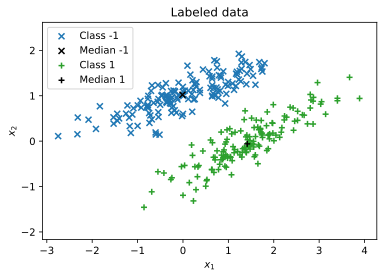

In [3]:
def plot_prediction(features, y_true, y_predicted):
    labels = np.unique(y_true)
    for i, (label, marker) in enumerate(zip(labels, "x+*.")):
        class_data = features[y_true == label]
        # Color is given by the predicted label
        colors = [f"C{predicted - labels.min()}" for predicted in y_predicted[y_true == label]]
        plt.scatter(class_data[:, 0], class_data[:, 1], marker=marker, label=f"Class {label}", c=colors)
        # Median is more stable than mean
        median = np.median(class_data, axis=0)
        plt.scatter(median[0], median[1], c="black", marker=marker, linewidths=10, label=f"Median {label}")
    plt.legend()
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.axis("equal")

plt.title("Labeled data")
plot_prediction(features, labels, labels)
x_range = plt.xlim()
y_range = plt.ylim()

In [4]:
def plot_decision_boundary(x_range, y_range, fit, samples=200, color="C1", margin=False):
    x, y = np.meshgrid(np.linspace(*x_range, samples), np.linspace(*y_range, samples))
    positions = np.stack((x.reshape(-1), y.reshape(-1)), axis=1).reshape(-1, 2)
    if margin:
        prediction = fit.decision_function(positions)
        levels = [-1, 0, 1]
        linestyles = ['--', '-', '--']
    else:
        prediction = fit.predict(positions)
        levels = [0]
        linestyles = ["-"]
    cntr = plt.contour(x, y, prediction.reshape(samples, samples),
                       colors=color, levels=[-1, 0, 1],
                       linestyles=linestyles)
    return cntr.legend_elements()[0][1]

def plot_prediction_grid(x_range, y_range, fit, samples=100):
    x, y = np.meshgrid(np.linspace(*x_range, samples), np.linspace(*y_range, samples))
    positions = np.stack((x.reshape(-1), y.reshape(-1)), axis=1).reshape(-1, 2)
    prediction = fit.predict_proba(positions)[:, 1]
    plt.imshow(prediction.reshape(samples, samples), origin="lower", extent=(x.min(), x.max(), y.min(), y.max()),
               cmap="coolwarm", vmin=0, vmax=1, alpha=0.3)
    plt.colorbar(label="Predicted Probability class -1")


## Mean discrimination

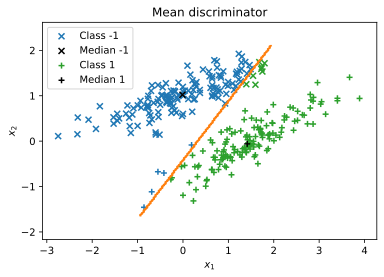

In [5]:
lmda = LinearDiscriminantAnalysis()
means = [np.median(features[labels == -1], axis=0), np.median(features[labels == 1], axis=0)] * 20
lmda.fit(means, [-1, 1] * 20)

plt.title("Mean discriminator")
predicted_labels = lmda.predict(features)
plot_decision_boundary(x_range, y_range, lmda)
plot_prediction(features, labels, predicted_labels)

## LDA

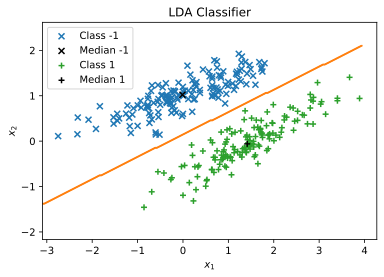

In [6]:
lda = LinearDiscriminantAnalysis()
lda.fit(features, labels)

plt.title("LDA Classifier")
predicted_labels = lda.predict(features)
plot_decision_boundary(x_range, y_range, lda)
plot_prediction(features, labels, predicted_labels)

## Linear SVM

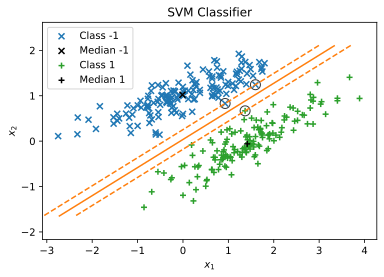

In [7]:
svm = SVC(gamma="scale", kernel="linear", C=1000)
svm.fit(features, labels)

plt.title("SVM Classifier")
predicted_labels = svm.predict(features)
plot_decision_boundary(x_range, y_range, svm, margin=True)
plot_prediction(features, labels, predicted_labels)
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1],
            s=100, linewidth=1, facecolors='none', edgecolors="k", 
            alpha=0.8)

## LR

In [8]:
def learn_and_show_lr(steps=100):
    lr = LogisticRegression(solver="lbfgs", max_iter=steps)
    lr.fit(features, labels)

    plt.title(f"Logistic regression ({steps} steps)")
    plot_prediction_grid(x_range, y_range, lr)
    plot_decision_boundary(x_range, y_range, lr)
    plot_prediction(features, labels, predicted_labels)

/Users/felix/miniconda3/envs/ml-tutorial/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/felix/miniconda3/envs/ml-tutorial/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


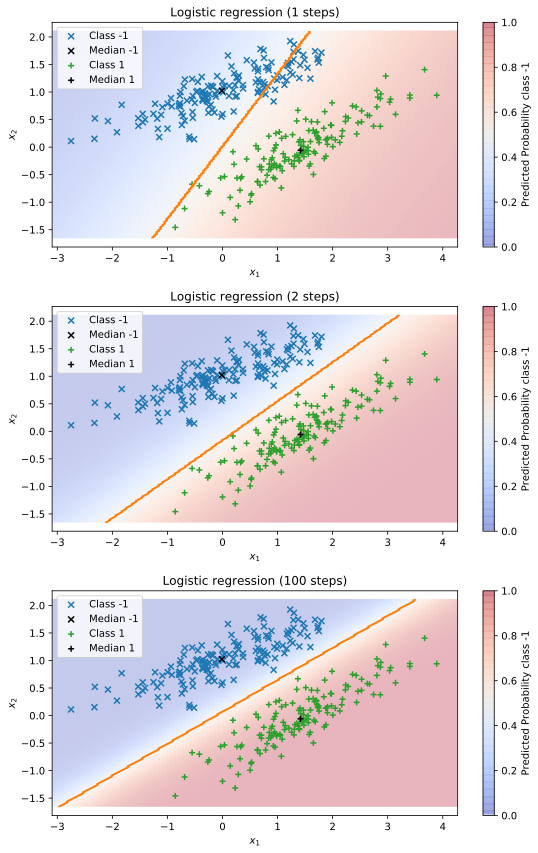

In [9]:
plt.figure(figsize=(8, 12))
plt.subplot(311)
learn_and_show_lr(1)
plt.subplot(312)
learn_and_show_lr(2)
plt.subplot(313)
learn_and_show_lr(100)
plt.tight_layout()

In [10]:
lr = LogisticRegression(solver="lbfgs")
lr.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Comparison

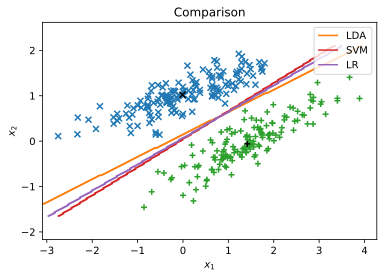

In [11]:
plt.title("Comparison")
plot_prediction(features, labels, labels)
lda_line = plot_decision_boundary(x_range, y_range, lda, color="C1")
svm_line = plot_decision_boundary(x_range, y_range, svm, color="C3")
lr_line = plot_decision_boundary(x_range, y_range, lr, color="C4")

plt.legend([lda_line, svm_line, lr_line], ["LDA", "SVM", "LR"])